In [1]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [2]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [3]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [4]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [5]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_squared_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [6]:
# load the dataset
series = read_csv("trafficnew.csv", header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)

In [7]:
# evaluate
mse, y, yhat = walk_forward_validation(data, 100)
print('MSE: %.3f' % mse)

>expected=1.3, predicted=220.9
>expected=360.3, predicted=474.6
>expected=537.1, predicted=184.4
>expected=9.7, predicted=358.1
>expected=10.2, predicted=180.4
>expected=0.0, predicted=57.4
>expected=120.1, predicted=145.7
>expected=7.5, predicted=322.3
>expected=80.9, predicted=183.6
>expected=1846.3, predicted=217.8
>expected=78.7, predicted=379.0
>expected=3.4, predicted=438.5
>expected=0.4, predicted=190.0
>expected=40.3, predicted=166.6
>expected=6.6, predicted=363.2
>expected=2.7, predicted=222.5
>expected=2.7, predicted=196.0
>expected=5.4, predicted=61.9
>expected=27.1, predicted=65.7
>expected=1.2, predicted=183.8
>expected=56.1, predicted=44.0
>expected=118.7, predicted=96.0
>expected=0.5, predicted=149.1
>expected=678.9, predicted=92.7
>expected=91.0, predicted=460.0
>expected=233.2, predicted=288.8
>expected=460.3, predicted=154.4
>expected=5.3, predicted=216.2
>expected=135.0, predicted=252.5
>expected=239.2, predicted=236.6
>expected=99.5, predicted=178.4
>expected=0.8, p

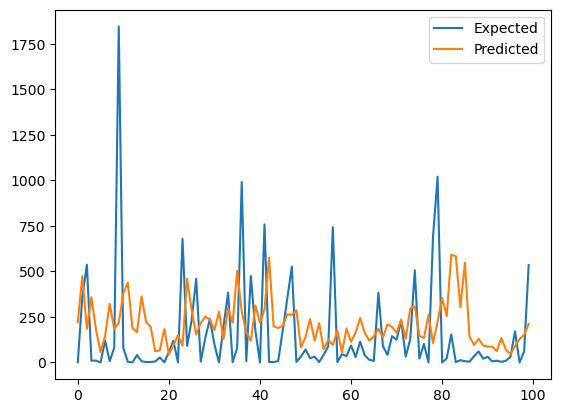

In [8]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()